# CLV and CLV Prediction

**Reference:** *https://www.kaggle.com/code/mehmeteryilmazz/clv-and-clv-prediction*

### Importing Required Libraries

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import pandas as pd
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


### 1. Connecting to DB

In [2]:
# Establish a connection to your SQLite database
conn = sqlite3.connect('temp.db')

### 2. Deriving Data

In [3]:
query = '''
SELECT
    s.sales_id,
    d.date,
    s.customer_id,
    s.transaction_id,
    p.product_category,
    p.SKU,
    s.quantity,
    p.price as unit_price
FROM
    date d 
JOIN
    sales_fact s ON d.date_id = s.date_id
JOIN
    product p ON s.product_id = p.product_id;
'''

In [4]:
# Read query results into a pandas DataFrame
df = pd.read_sql_query(query, conn)
df.head()

,sales_id,date,customer_id,transaction_id,product_category,SKU,quantity,unit_price
0,1,2021-06-05,1098,0,Clothing,4C555,4,44.96000
1,2,2021-06-05,1098,0,Beauty,25F7D,10,90.25000
2,3,2021-06-05,1098,0,Industrial,805A9,13,62.01000
3,4,2021-06-05,1098,0,Automotive,E5CE6,12,1.26000
4,5,2019-12-24,592,1,Electronics,6C804,11,48.97000


In [5]:
# Trying to understand the data.

def check_df(dataframe, head=7):
    print("################### Shape ####################")
    print(dataframe.shape)
    print("#################### Info #####################")
    print(dataframe.info())
    print("################### Nunique ###################")
    print(dataframe.nunique())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("################## Quantiles #################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("#################### Head ####################")
    print(dataframe.head(head))

check_df(df)

################### Shape ####################
(12065, 8)
#################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12065 entries, 0 to 12064
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sales_id          12065 non-null  int64  
 1   date              12065 non-null  object 
 2   customer_id       12065 non-null  int64  
 3   transaction_id    12065 non-null  int64  
 4   product_category  12065 non-null  object 
 5   SKU               12065 non-null  object 
 6   quantity          12065 non-null  int64  
 7   unit_price        12065 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 754.2+ KB
None
################### Nunique ###################
sales_id            12065
date                 3206
customer_id          2186
transaction_id       4000
product_category       22
SKU                  4582
quantity               19
unit_price       

### **What is Customer Lifetime Value(CLV)?**

***The monetary value a customer will bring to a company during their relationship and communication is known as "customer lifetime value."***

This will be achieved by using the formulas below:

* **Repeat rate:** number of customers who make multiple purchases / all customers

* **Churn rate:** 1 - repeat rate

* **Purchase frequency:** total transactions / total number of unique customers

* **Average order value:** total price / total transactions

* **Customer value:** average order value * purchase frequency

* **Profit margin:** total price * profit margin rate(provided by the company)

* **CLV** = (customer value / churn rate) * profit margin

*Customers are segmented based on the generated CLV value, and operations are carried out according to these segments.*

#### **Dataset Details**

* **sale_id**: Unique Sale ID Number for each Respective Sale

* **date**: Date of Sales Transaction

* **customer_id**: Unique Customer iID for each Customer

* **transaction_id**: ID of the Transaction

* **product_category**: Product Category Name

* **SKU**: Product Code

* **quantity**: Number of Items Sold in the Transaction

* **unit_price** : Unit Price of the Respective Product

In [6]:
# finding the total sale amount for each transaction.
df["sales_amount"] = df["unit_price"] * df["quantity"]

# accessing the values required for the formulas.
cltv = df.groupby('customer_id').agg({'transaction_id': lambda x: x.nunique(),  # total transaction
                                        'sales_amount': lambda x: x.sum()})     # total price

# changing the names of the variables we have created.
cltv.columns = ['total_transaction', 'total_price']

cltv.head()

,total_transaction,total_price
customer_id,,
0,2,2709.35000
1,1,3405.42000
2,1,1679.49000
3,2,3427.36000
4,4,10040.15000


In [7]:
# Average Order Value (average_order_value = total_price / total_transaction)
cltv["average_order_value"] = cltv["total_price"] / cltv["total_transaction"]

# Purchase Frequency (total_transaction / total_number_of_customers)
cltv.shape[0]  # total number of customers
cltv["purchase_frequency"] = cltv["total_transaction"] / cltv.shape[0]

# Repeat Rate & Churn Rate
# (number of customers who make multiple purchases / all customers)
repeat_rate = cltv[cltv["total_transaction"] > 1].shape[0] / cltv.shape[0]
churn_rate = 1 - repeat_rate

# Profit Margin (total price * profit margin rate)
# Setting the profit margin rate as 0.10.
cltv['profit_margin'] = cltv['total_price'] * 0.10

# Customer Value (customer_value = average_order_value * purchase_frequency)
cltv['customer_value'] = cltv['average_order_value'] * cltv["purchase_frequency"]

# Customer Lifetime Value (CLV = (customer_value / churn_rate) x profit_margin)
cltv["cltv"] = (cltv["customer_value"] / churn_rate) * cltv["profit_margin"]

cltv.head()

,total_transaction,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
customer_id,,,,,,,
0,2,2709.35000,1354.67500,0.00091,270.93500,1.23941,716.85326
1,1,3405.42000,3405.42000,0.00046,340.54200,1.55783,1132.50834
2,1,1679.49000,1679.49000,0.00046,167.94900,0.76829,275.45768
3,2,3427.36000,1713.68000,0.00091,342.73600,1.56787,1147.14810
4,4,10040.15000,2510.03750,0.00183,1004.01500,4.59293,9844.20039


In [8]:
# Creating the Segments

# Dividing the CLTV values into 4 parts and creating a segment variable.
cltv["segment"] = pd.qcut(cltv["cltv"], 4, labels=["D", "C", "B", "A"])

cltv.sort_values(by="cltv", ascending=False).head()

,total_transaction,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv,segment
customer_id,,,,,,,,
36,5,13330.71000,2666.14200,0.00229,1333.07100,6.09822,17354.28019,A
1366,7,13066.54000,1866.64857,0.00320,1306.65400,5.97737,16673.28785,A
1963,5,13005.09000,2601.01800,0.00229,1300.50900,5.94926,16516.83261,A
1184,5,12743.08000,2548.61600,0.00229,1274.30800,5.82941,15858.01640,A
1247,5,12728.07000,2545.61400,0.00229,1272.80700,5.82254,15820.68027,A


In [9]:
# Creating count, mean, and sum values for all other variables based on the segments.
cltv.groupby("segment").agg({"count", "mean", "sum"})

# Thus, we can perform operations on customers based on their segments.

total_transaction                 total_price                  average_order_value                  purchase_frequency               profit_margin                 customer_value                        cltv                 
                      sum    mean count           sum       mean count                 sum       mean count                sum    mean count           sum      mean count            sum    mean count           sum       mean count
segment                                                                                                                                                                                                                               
D                     624 1.14077   547  372034.01000  680.13530   547        341016.06833  623.42974   547            0.28545 0.00052   547   37203.40100  68.01353   547      170.18939 0.31113   547   31428.48522   57.45610   547
C                     765 1.40110   546  978890.74000 1792.84018   546        794345.61500 1454.84545   546            0.34995 0.00064   546   97889.07400 179.28402   546      447.79997 0.82015   546  176741.74446  323.70283   546
B                    1047 1.91758   546 1702866.32000 3118.80278   546       1038962.39167 1902.86152   546            0.47896 0.00088   546  170286.63200 311.88028   546      778.98734 1.42672   546  529369.09671  969.54047   546
A                    1564 2.85923   547 3089417.68000 5647.92995   547       1169123.04074 2137.33645   547            0.71546 0.00131   547  308941.76800 564.79299   547     1413.27433 2.58368   547 1851696.10621 3385.18484   547

### **CLV Prediction with BG-NBD and Gamma-Gamma**

***CLTV Prediction: BG/NBD Gamma gamma submodel***

Hereby, performing CLTV prediction with BG/NBD and Gamma-Gamma.

#### Expected Number of Transactions with BG/NBD.

BG/NBD is used as a standalone sales prediction model, that is; it predicts the expected number of purchases per customer.

**The information we need to use in this model and learn from the customer is:**

* **x:** Number of repeated purchases by the customer (more than 1) (frequency)

* **tx:** Time between a customer's first and last purchase

* **T:** Time since the customer's first purchase (customer's age)

#### Gamma Gamma SubModel

It is used to estimate how much profit a customer can bring per transaction on average.

**The information we need to use in this model and learn from the customer is:**

* **x:** Number of repeated purchases by the customer (more than 1) (frequency)

* **mx:** These are the observed transaction values, i.e., the monetary value, i.e., total price/total transaction.

In [10]:
# Data Preparation

# Converting the date in object format to datetime format using the datetime module.
df["date"] = pd.to_datetime(df["date"])

In [11]:
# Find the last date and make transactions starting from 2 days later.
df["date"].max()  # '2023-12-29'
today_date = pd.to_datetime("2023-12-31")

In [12]:
# Calculating the necessary values for our calculations.
cltv_pr = df.groupby('customer_id').agg(
    {'date': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,  # tx: recency degeri
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],         # T: customer's age
     'transaction_id': lambda Invoice: Invoice.nunique(),    # x: frequency degeri 
     'sales_amount': lambda TotalPrice: TotalPrice.sum()})

# The variables in the output are displayed in two rows. Need to remove the first row.
cltv_pr.columns = cltv_pr.columns.droplevel(0)

# Changing the names of the variables we have created.
cltv_pr.columns = ['recency', 'T', 'frequency', 'monetary']

# mx: monetary degeri. total price/frequency
cltv_pr["monetary"] = cltv_pr["monetary"] / cltv_pr["frequency"]

# The frequency refers to customers who made more than one purchase.
cltv_pr = cltv_pr[(cltv_pr['frequency'] > 1)]

# Converting the recency value into weekly time.
cltv_pr["recency"] = cltv_pr["recency"] / 7

# Converting the customer's age into weekly time.
cltv_pr["T"] = cltv_pr["T"] / 7

cltv_pr.head()

,recency,T,frequency,monetary
customer_id,,,,
0,477.14286,542.28571,2,1354.67500
3,241.28571,841.57143,2,1713.68000
4,563.00000,930.14286,4,2510.03750
6,639.28571,1230.42857,2,2058.61500
8,395.57143,701.28571,2,888.03000


In [13]:
# Setting up the BG-NBD Model

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_pr['frequency'],       
        cltv_pr['recency'],
        cltv_pr['T'])


# Which are the top 10 customers that are expected to have the most purchases within the a month?

cltv_pr["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_pr['frequency'],
                                               cltv_pr['recency'],
                                               cltv_pr['T'])


# What is the expected number of sales for the entire company in 3 months?

cltv_pr["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_pr['frequency'],
                                               cltv_pr['recency'],
                                               cltv_pr['T'])

cltv_pr.head()

,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month
customer_id,,,,,,
0,477.14286,542.28571,2,1354.67500,0.01290,0.03859
3,241.28571,841.57143,2,1713.68000,0.00387,0.01159
4,563.00000,930.14286,4,2510.03750,0.00904,0.02704
6,639.28571,1230.42857,2,2058.61500,0.00454,0.01359
8,395.57143,701.28571,2,888.03000,0.00863,0.02581


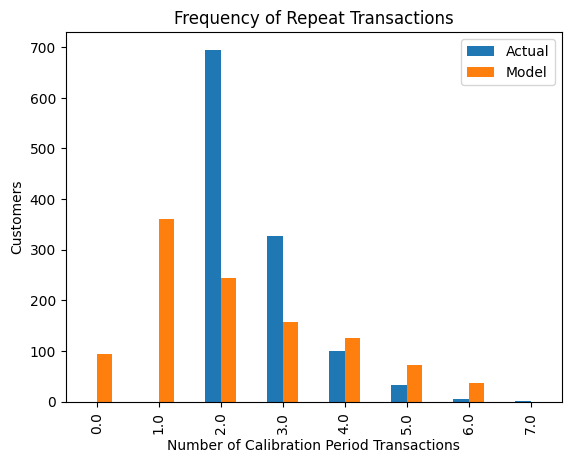

In [14]:
# Evaluation of Prediction Results

plot_period_transactions(bgf)
plt.show()

In [15]:
# Setting up the Gamma-Gamma Model

ggf = GammaGammaFitter(penalizer_coef=0.01)  

ggf.fit(cltv_pr['frequency'], cltv_pr['monetary'])


# We are seeing the profit prediction for customers.
cltv_pr["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_pr['frequency'],
                                                                             cltv_pr['monetary'])


cltv_pr.sort_values("expected_average_profit", ascending=False).head(5)

,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month,expected_average_profit
customer_id,,,,,,,
1278,457.14286,598.71429,2,3928.58000,0.01156,0.03458,4461.31518
2749,257.71429,375.00000,2,3848.40000,0.01322,0.03954,4370.29954
2666,103.85714,850.28571,2,3629.34500,0.00214,0.00640,4121.64115
2108,375.00000,911.57143,2,3588.96500,0.00490,0.01468,4075.80414
2650,47.42857,477.71429,2,3572.11000,0.00613,0.01834,4056.67133


In [16]:
# Calculation of CLV prediction using BG-NBD and GG models.

# CLTV Prediction: BG/NBD * Gamma gamma submodel

#Calculating the 3-month CLV prediction.
cltv_pred = ggf.customer_lifetime_value(bgf,
                                   cltv_pr['frequency'],
                                   cltv_pr['recency'],
                                   cltv_pr['T'],
                                   cltv_pr['monetary'],
                                   time=3,  
                                   freq="W",  # T and frequency time interval; week(W)
                                   discount_rate=0.01)

cltv_pred = cltv_pred.reset_index()

cltv_pred.head()

,customer_id,clv
0,0,63.24216
1,3,24.02734
2,4,76.85824
3,6,33.82320
4,8,27.74460


In [17]:
#Combine CLV predictions with other variables.
cltv_prediction = cltv_pr.merge(cltv_pred, on="customer_id", how="left")

cltv_prediction.head()

,customer_id,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
0,0,477.14286,542.28571,2,1354.67500,0.01290,0.03859,1539.56913,63.24216
1,3,241.28571,841.57143,2,1713.68000,0.00387,0.01159,1947.09055,24.02734
2,4,563.00000,930.14286,4,2510.03750,0.00904,0.02704,2669.76060,76.85824
3,6,639.28571,1230.42857,2,2058.61500,0.00454,0.01359,2338.64054,33.82320
4,8,395.57143,701.28571,2,888.03000,0.00863,0.02581,1009.86108,27.74460


In [18]:
# Creating Segments Based on CLV

# Dividing the CLV predictions into 4 parts and creating a segment variable.
cltv_prediction["segment"] = pd.qcut(cltv_prediction["clv"], 4, labels=["D", "C", "B", "A"])

cltv_prediction.sort_values(by="clv", ascending=False).head()

,customer_id,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
1060,2749,257.71429,375.00000,2,3848.40000,0.01322,0.03954,4370.29954,183.92709,A
153,338,276.42857,292.71429,2,2961.82500,0.01551,0.04636,3363.91158,166.00005,A
654,1631,364.28571,385.28571,2,3112.98500,0.01462,0.04372,3535.49955,164.52003,A
516,1278,457.14286,598.71429,2,3928.58000,0.01156,0.03458,4461.31518,164.24772,A
967,2518,261.28571,283.14286,2,2825.80500,0.01551,0.04639,3209.50965,158.47252,A


In [19]:
# Creating count, mean, and sum values for all other variables based on the segments.
cltv_prediction.groupby("segment").agg(
    {"count", "mean", "sum"})


# Thus, we can perform operations on customers based on their segments.

customer_id                       recency                            T                 frequency                   monetary                  expected_purc_1_month               expected_purc_3_month               expected_average_profit                          clv               
                sum       mean count          sum      mean count          sum      mean count       sum    mean count          sum       mean count                   sum    mean count                   sum    mean count                     sum       mean count         sum     mean count
segment                                                                                                                                                                                                                                                                                         
D            413821 1422.06529   291  86240.28571 296.35837   291 287330.85714 987.39126   291       675 2.31959   291 344735.68200 1184.65870   291               1.06872 0.00367   291               3.19821 0.01099   291            387088.65062 1330.20155   291  3279.59998 11.27010   291
C            423530 1460.44828   290 149100.00000 514.13793   290 265252.57143 914.66404   290       717 2.47241   290 385069.87517 1327.82716   290               2.10135 0.00725   290               6.28843 0.02168   290            430472.77605 1484.38888   290  8588.57648 29.61578   290
B            432363 1490.90690   290 177071.71429 610.59212   290 250816.00000 864.88276   290       764 2.63448   290 459944.23983 1586.01462   290               2.82542 0.00974   290               8.45469 0.02915   290            511512.52654 1763.83630   290 14746.43608 50.84978   290
A            444161 1526.32646   291 186077.14286 639.44035   291 225164.85714 773.76240   291       820 2.81787   291 604991.47874 2079.00852   291               3.57249 0.01228   291              10.68868 0.03673   291            669004.33486 2298.98397   291 25456.68779 87.48003   291